In [1]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


In [2]:
 pip install beautifulsoup4 

Note: you may need to restart the kernel to use updated packages.


In [3]:
 pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Scan and Parse news

In [5]:
import os

def get_news_articles(days=14, save_to_csv=True, csv_filename=None):
    """
    Scrape news articles from PR Newswire for the specified number of days.
    
    Args:
        days (int): Number of days to look back (default: 14)
        save_to_csv (bool): Whether to save results to CSV (default: True)
        csv_filename (str): Custom filename for CSV (default: auto-generated)
    
    Returns:
        list: List of dictionaries containing article data
    """
    base_url = "https://www.prnewswire.com/news-releases/news-releases-list/"
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    
    # Format dates for URL
    start_str = start_date.strftime("%m/%d/%Y")
    end_str = end_date.strftime("%m/%d/%Y")
    
    url = f"{base_url}?page=1&pagesize=100&startdate={start_str}&enddate={end_str}&searchterm="
    
    try:
        print(f"Fetching news articles from {start_str} to {end_str}...")
        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        
        articles = []
        for item in soup.find_all('div', class_='row newsCards'):
            title = item.find('h3').text.strip() if item.find('h3') else "No title"
            date = item.find('small').text.strip() if item.find('small') else "No date"
            summary = item.find('p').text.strip() if item.find('p') else "No summary"
            link = "https://www.prnewswire.com" + item.find('a')['href'] if item.find('a') else "No link"
            
            articles.append({
                'title': title,
                'date': date,
                'summary': summary,
                'link': link,
                'scraped_at': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            })
        
        print(f"Found {len(articles)} articles.")
        
        # Save to CSV if requested
        if save_to_csv and articles:
            if csv_filename is None:
                csv_filename = f"prnewswire_articles_{start_date.strftime('%Y%m%d')}_to_{end_date.strftime('%Y%m%d')}.csv"
            
            # Create directory if it doesn't exist
            os.makedirs('scraped_data', exist_ok=True)
            full_path = os.path.join('scraped_data', csv_filename)
            
            df = pd.DataFrame(articles)
            df.to_csv(full_path, index=False)
            print(f"Saved articles to {full_path}")
        
        return articles
    
    except requests.exceptions.RequestException as e:
        print(f"Network error occurred: {e}")
        return []
    except Exception as e:
        print(f"Error fetching news: {e}")
        return []

def display_sample_articles(articles, num=3):
    """Display sample articles for verification."""
    if not articles:
        print("No articles to display.")
        return
    
    print("\nSample Articles:")
    for i, article in enumerate(articles[:num], 1):
        print(f"\nArticle {i}:")
        print(f"Title: {article['title']}")
        print(f"Date: {article['date']}")
        print(f"Summary: {article['summary'][:100]}...")
        print(f"Link: {article['link']}")

def main():
    """Main function to execute Part 1 functionality."""
    print("=== PR Newswire Article Scraper ===")
    
    # Get articles from the last 7 days and save to CSV
    articles = get_news_articles(days=7, save_to_csv=True)
    
    # Display sample results
    display_sample_articles(articles)
    
    print("\nScraping completed successfully!")

if __name__ == "__main__":
    main()

=== PR Newswire Article Scraper ===
Fetching news articles from 04/08/2025 to 04/15/2025...
Found 98 articles.
Saved articles to scraped_data\prnewswire_articles_20250408_to_20250415.csv

Sample Articles:

Article 1:
Title: 19:55 ET
			
			
				RKLB Investors Have Opportunity to Lead Rocket Lab USA, Inc. Securities Fraud Lawsuit
Date: 19:55 ET
Summary: Rosen Law Firm, a global investor rights law firm, reminds purchasers of securities of Rocket Lab US...
Link: https://www.prnewswire.com/news-releases/rklb-investors-have-opportunity-to-lead-rocket-lab-usa-inc-securities-fraud-lawsuit-302429599.html

Article 2:
Title: 19:46 ET
			
			
				Maravai LifeSciences Holdings, Inc. Deadline Approaching:  Kessler Topaz Meltzer & Check, LLP Reminds Maravai LifeSciences Holdings, Inc. Investors of Deadline in Securities Fraud Class Action Lawsuit
Date: 19:46 ET
Summary: The law firm of Kessler Topaz Meltzer & Check, LLP (www.ktmc.com) informs investors that a securitie...
Link: https://www.prnewswi

 Track/Store/Search

In [6]:
import re

def extract_stock_symbols(text, industry="technology"):
    """
    Extract stock symbols from text with industry filtering
    Returns: list of found symbols (e.g., ['TSX:SHOP', 'NASDAQ:AAPL'])
    """
    # Define industry keywords
    industry_keywords = {
        "technology": ["tech", "software", "hardware", "AI", "artificial intelligence", "cloud", "cybersecurity"],
        "finance": ["bank", "financial", "investment", "stock", "market", "trading", "exchange"],
        "healthcare": ["pharma", "health", "medical", "biotech", "hospital", "vaccine", "treatment"]
    }.get(industry.lower(), ["tech", "software"])  # Default to tech
    
    # Stock symbol patterns (TSX:XXX, NASDAQ:XXX, NYSE:XXX)
    patterns = [
        r'(TSX\s*:\s*[A-Z]{1,5})',
        r'(NASDAQ\s*:\s*[A-Z]{1,5})', 
        r'(NYSE\s*:\s*[A-Z]{1,5})',
        r'([A-Z]{2,5}\s*:\s*[A-Z]{1,5})'
    ]
    
    found_symbols = []
    
    # Only search if text contains industry keywords
    if any(keyword.lower() in text.lower() for keyword in industry_keywords):
        for pattern in patterns:
            matches = re.findall(pattern, text.upper())
            found_symbols.extend([match.replace(" ", "") for match in matches])
    
    return list(set(found_symbols))[:3]  # Return max 3 unique symbols

def process_and_store_news(articles, industry="technology", output_format="csv"):
    """
    Process articles and store with stock symbols
    Supports multiple output formats: csv, excel, json
    Returns: DataFrame and saved file path
    """
    processed_data = []
    all_symbols = set()
    
    for article in articles:
        full_text = f"{article['title']} {article['summary']}"
        symbols = extract_stock_symbols(full_text, industry)
        
        processed_data.append({
            **article,
            "industry": industry,
            "symbols": ", ".join(symbols),
            "symbol_count": len(symbols)
        })
        all_symbols.update(symbols)
    
    df = pd.DataFrame(processed_data)
    
    # Save to different formats
    os.makedirs("tracked_data", exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    if output_format == "csv":
        file_path = f"tracked_data/news_with_stocks_{timestamp}.csv"
        df.to_csv(file_path, index=False)
    elif output_format == "excel":
        file_path = f"tracked_data/news_with_stocks_{timestamp}.xlsx"
        df.to_excel(file_path, index=False)
    elif output_format == "json":
        file_path = f"tracked_data/news_with_stocks_{timestamp}.json"
        df.to_json(file_path, orient="records")
    else:
        file_path = None
    
    print(f"\nTracking Summary:")
    print(f"- Processed {len(df)} articles")
    print(f"- Found {len(all_symbols)} unique stock symbols")
    print(f"- Saved to {file_path or 'memory only'}")
    
    if not df.empty:
        print("\nSample stored data:")
        print(df[["date", "title", "symbols"]].head(2))
    
    return df, file_path

# Updated main() function incorporating Part 2:
def main():
    print("=== News Tracking System ===")
    
    # Part 1: Get news articles (from previous implementation)
    articles = get_news_articles(days=7)
    if not articles:
        return
    
    # Part 2: Process and store with stock symbols
    industry = "technology"  # Change to "finance" or "healthcare" as needed
    df_tracked, file_path = process_and_store_news(
        articles,
        industry=industry,
        output_format="csv"  # Change to "excel" or "json" as needed
    )
    
    # Show statistics
    if not df_tracked.empty:
        print("\nSymbol Frequency:")
        print(df_tracked["symbols"].value_counts().head(5))
        
        print("\nArticles with most symbols:")
        print(df_tracked.sort_values("symbol_count", ascending=False)[["title", "symbols"]].head(3))

if __name__ == "__main__":
    main()

=== News Tracking System ===
Fetching news articles from 04/08/2025 to 04/15/2025...
Found 98 articles.
Saved articles to scraped_data\prnewswire_articles_20250408_to_20250415.csv

Tracking Summary:
- Processed 98 articles
- Found 29 unique stock symbols
- Saved to tracked_data/news_with_stocks_20250415_200141.csv

Sample stored data:
       date                                              title      symbols
0  19:55 ET  19:55 ET\n\t\t\t\n\t\t\t\n\t\t\t\tRKLB Investo...             
1  19:46 ET  19:46 ET\n\t\t\t\n\t\t\t\n\t\t\t\tMaravai Life...  CHING:KESSL

Symbol Frequency:
symbols
                                        77
WHY:ROSEN                                2
CHING:KESSL                              2
NTALS:CMASN                              1
ASDAQ:SSNC, NASDAQ:SSNC, MAAKT:GOVER     1
Name: count, dtype: int64

Articles with most symbols:
                                                title  \
97  14:37 ET\n\t\t\t\n\t\t\t\n\t\t\t\tSMTC Deadlin...   
85  15:02 ET\nStrategisc

 Retrieve Data (Web (API))

In [7]:
# UPDATED TARGET SYMBOLS (TSLA REMOVED)
TARGET_SYMBOLS = {
    'AAPL': ['apple', 'aapl', 'nasdaq:aapl'],
    'NVDA': ['nvidia', 'nvda', 'nasdaq:nvda'],
    'MSFT': ['microsoft', 'msft', 'nasdaq:msft'],
    'AMZN': ['amazon', 'amzn', 'nasdaq:amzn']
}

def extract_target_symbols(text, industry="technology"):
    """
    Now searches for 4 target tech companies (TSLA removed)
    Returns formatted symbols like 'NASDAQ:AAPL'
    """
    # Enhanced industry keywords
    industry_keywords = {
        "technology": [
            "tech", "software", "hardware", "ai", "artificial intelligence",
            "gpu", "chip", "semiconductor", "cloud", "e-commerce",
            "operating system", "cloud computing", "macbook", "windows"
        ],
        "finance": ["stock", "market", "trading", "shares"],  # Not used here
    }.get(industry.lower(), ["tech"])
    
    found_symbols = []
    text_lower = text.lower()
    
    # Only proceed if text contains industry keywords
    if any(kw in text_lower for kw in industry_keywords):
        # Search for all target symbols and their variants
        for symbol, aliases in TARGET_SYMBOLS.items():
            # Check for any alias match (e.g., "microsoft" or "msft")
            if any(alias in text_lower for alias in aliases):
                # Standardize format to NASDAQ:SYMBOL
                found_symbols.append(f"NASDAQ:{symbol}")
    
    return list(set(found_symbols))[:4]  # Max 4 symbols now

def process_and_store_tech_stocks(articles, output_format="csv"):
    """
    Tracks 4 tech giants with enhanced reporting
    """
    processed_data = []
    found_counts = {symbol: 0 for symbol in TARGET_SYMBOLS.keys()}
    
    for article in articles:
        full_text = f"{article['title']} {article['summary']}"
        symbols = extract_target_symbols(full_text)
        
        # Update discovery counts
        for sym in symbols:
            ticker = sym.split(':')[-1]
            if ticker in found_counts:
                found_counts[ticker] += 1
        
        processed_data.append({
            'date': article.get('date', ''),
            'title': article.get('title', ''),
            'summary': article.get('summary', ''),
            'url': article.get('url', ''),
            'symbols': ', '.join(symbols),
            'symbol_count': len(symbols)
        })
    
    df = pd.DataFrame(processed_data)
    
    # Save to file
    os.makedirs("tech_stock_news", exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    if output_format == "csv":
        file_path = f"tech_stock_news/tech_giants_news_{timestamp}.csv"
        df.to_csv(file_path, index=False)
    elif output_format == "excel":
        file_path = f"tech_stock_news/tech_giants_news_{timestamp}.xlsx"
        df.to_excel(file_path, index=False)
    
    print(f"\nTech Giants Tracking Summary (TSLA Removed):")
    for symbol, count in found_counts.items():
        print(f"- {symbol} mentioned in {count} articles")
    print(f"- Data saved to {file_path}")
    
    # Generate individual reports
    for symbol in TARGET_SYMBOLS.keys():
        symbol_df = df[df['symbols'].str.contains(symbol)]
        if not symbol_df.empty:
            symbol_df.to_csv(f"tech_stock_news/{symbol}_news.csv", index=False)
            print(f"  → Generated {symbol}_news.csv")
    
    return df, file_path

def main():
    print("=== Tech Giants News Tracker (AAPL, NVDA, MSFT, AMZN) ===")
    
    # Sample news data - replace with your actual scraped articles
    sample_articles = [
        {
            "title": "Apple and Microsoft partner on AI integration",
            "summary": "AAPL and MSFT announced new AI features for iOS and Windows",
            "date": "2024-06-11",
            "url": "https://example.com/apple-microsoft-ai"
        },
        {
            "title": "Amazon Web Services adopts Nvidia's new GPUs",
            "summary": "AMZN becomes first cloud provider to offer NVDA's H200 instances",
            "date": "2024-06-10",
            "url": "https://example.com/aws-nvidia"
        },
        {
            "title": "Microsoft unveils new Surface devices with Apple M3 chips",
            "summary": "MSFT surprises with AAPL processor in new tablets",
            "date": "2024-06-09",
            "url": "https://example.com/surface-m3"
        }
    ]
    
    # Process and store
    df, path = process_and_store_tech_stocks(sample_articles, output_format="csv")
    
    print("\nSample Findings:")
    print(df[['date', 'title', 'symbols']].head())

if __name__ == "__main__":
    main()

=== Tech Giants News Tracker (AAPL, NVDA, MSFT, AMZN) ===

Tech Giants Tracking Summary (TSLA Removed):
- AAPL mentioned in 2 articles
- NVDA mentioned in 1 articles
- MSFT mentioned in 2 articles
- AMZN mentioned in 1 articles
- Data saved to tech_stock_news/tech_giants_news_20250415_200207.csv
  → Generated AAPL_news.csv
  → Generated NVDA_news.csv
  → Generated MSFT_news.csv
  → Generated AMZN_news.csv

Sample Findings:
         date                                              title  \
0  2024-06-11      Apple and Microsoft partner on AI integration   
1  2024-06-10       Amazon Web Services adopts Nvidia's new GPUs   
2  2024-06-09  Microsoft unveils new Surface devices with App...   

                    symbols  
0  NASDAQ:AAPL, NASDAQ:MSFT  
1  NASDAQ:NVDA, NASDAQ:AMZN  
2  NASDAQ:AAPL, NASDAQ:MSFT  


In [9]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import os
import time

def get_stock_data(symbols, days=30):
    """
    Retrieve historical stock data for multiple symbols from Yahoo Finance
    Args:
        symbols: List of stock symbols (e.g., ['NASDAQ:AAPL', 'TSX:SHOP'])
        days: Number of days of data to retrieve (default: 30)
    Returns:
        dict: Dictionary of DataFrames with historical data for each symbol
    """
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    
    stock_data = {}
    
    for symbol in symbols:
        try:
            # Clean symbol (remove exchange prefix)
            clean_symbol = symbol.split(':')[-1]
            
            print(f"\nRetrieving {days} days of data for {symbol}...")
            
            # Download historical data
            data = yf.download(
                clean_symbol,
                start=start_date,
                end=end_date,
                progress=False
            )
            
            if not data.empty:
                # Add metadata and calculations
                data['Symbol'] = symbol
                data['Daily_Change_Pct'] = data['Close'].pct_change() * 100
                data['5_Day_MA'] = data['Close'].rolling(5).mean()
                
                stock_data[symbol] = data
                print(f"✅ Success: Retrieved {len(data)} trading days")
                print(f"   Date Range: {data.index[0].date()} to {data.index[-1].date()}")
            else:
                print(f"⚠️ Warning: No data available for {symbol}")
                
            # Polite delay between requests
            time.sleep(1)
            
        except Exception as e:
            print(f"❌ Error fetching {symbol}: {str(e)}")
    
    return stock_data

def save_stock_data(stock_data, output_dir="stock_data"):
    """
    Save retrieved stock data to CSV files
    Args:
        stock_data: Dictionary of DataFrames from get_stock_data()
        output_dir: Directory to save files (default: 'stock_data')
    Returns:
        list: Paths to saved files
    """
    os.makedirs(output_dir, exist_ok=True)
    saved_files = []
    
    for symbol, data in stock_data.items():
        filename = f"{output_dir}/{symbol.replace(':', '_')}_history.csv"
        data.to_csv(filename)
        saved_files.append(filename)
        print(f"💾 Saved {symbol} data to {filename}")
    
    return saved_files

def generate_stock_report(stock_data, filename="stock_report.csv"):
    """
    Generate and save a summary report of key metrics
    Args:
        stock_data: Dictionary of DataFrames from get_stock_data()
        filename: Output filename (default: 'stock_report.csv')
    Returns:
        DataFrame: The generated report
    """
    report_data = []
    
    for symbol, data in stock_data.items():
        if len(data) > 0:
            latest = data.iloc[-1]
            first = data.iloc[0]
            
            # Ensure we're working with numeric values
            try:
                start_price = float(first['Close'])
                end_price = float(latest['Close'])
                price_change_pct = (end_price - start_price) / start_price * 100
                
                report_data.append({
                    'Symbol': symbol,
                    'Start_Date': data.index[0].strftime('%Y-%m-%d'),
                    'End_Date': data.index[-1].strftime('%Y-%m-%d'),
                    'Days_Retrieved': len(data),
                    'Start_Price': round(start_price, 2),
                    'End_Price': round(end_price, 2),
                    'Price_Change_Pct': round(price_change_pct, 2),
                    '30_Day_High': round(float(data['High'].max()), 2),
                    '30_Day_Low': round(float(data['Low'].min()), 2),
                    'Avg_Daily_Volume': f"{int(data['Volume'].mean()):,}",
                    'Latest_Volume': f"{int(latest['Volume']):,}"
                })
            except (ValueError, TypeError) as e:
                print(f"⚠️ Error processing {symbol}: {str(e)}")
                continue
    
    report_df = pd.DataFrame(report_data)
    
    # Save report
    report_df.to_csv(filename, index=False)
    print(f"\n📋 Generated summary report: {filename}")
    
    return report_df

def main():
    print("=== Yahoo Finance Stock Data Retriever ===")
    print("Retrieving last 30 days of price and volume data...\n")
    
    # Example symbols (replace with your actual symbols from news analysis)
    symbols = ['NASDAQ:AAPL', 'NASDAQ:NVDA', 'NYSE:MSFT']
    
    # 1. Retrieve the stock data
    stock_data = get_stock_data(symbols)
    
    if not stock_data:
        print("\nNo stock data retrieved. Exiting.")
        return
    
    # 2. Save the raw data
    save_stock_data(stock_data)
    
    # 3. Generate and display report
    report_df = generate_stock_report(stock_data)
    
    print("\n=== Stock Performance Summary ===")
    print(report_df.to_string(index=False))
    
    # Show sample data
    sample_symbol = list(stock_data.keys())[0]
    print(f"\nSample data for {sample_symbol}:")
    print(stock_data[sample_symbol][['Close', 'Volume', 'Daily_Change_Pct']].tail(3))

if __name__ == "__main__":
    main()
    

=== Yahoo Finance Stock Data Retriever ===
Retrieving last 30 days of price and volume data...


Retrieving 30 days of data for NASDAQ:AAPL...
✅ Success: Retrieved 22 trading days
   Date Range: 2025-03-17 to 2025-04-15

Retrieving 30 days of data for NASDAQ:NVDA...
✅ Success: Retrieved 22 trading days
   Date Range: 2025-03-17 to 2025-04-15

Retrieving 30 days of data for NYSE:MSFT...
✅ Success: Retrieved 22 trading days
   Date Range: 2025-03-17 to 2025-04-15
💾 Saved NASDAQ:AAPL data to stock_data/NASDAQ_AAPL_history.csv
💾 Saved NASDAQ:NVDA data to stock_data/NASDAQ_NVDA_history.csv
💾 Saved NYSE:MSFT data to stock_data/NYSE_MSFT_history.csv

📋 Generated summary report: stock_report.csv

=== Stock Performance Summary ===
     Symbol Start_Date   End_Date  Days_Retrieved  Start_Price  End_Price  Price_Change_Pct  30_Day_High  30_Day_Low Avg_Daily_Volume Latest_Volume
NASDAQ:AAPL 2025-03-17 2025-04-15              22       214.00     202.14             -5.54       225.62      169.21    

C:\Users\rozyp\AppData\Local\Temp\ipykernel_27328\2785901605.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  start_price = float(first['Close'])
C:\Users\rozyp\AppData\Local\Temp\ipykernel_27328\2785901605.py:95: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  end_price = float(latest['Close'])
C:\Users\rozyp\AppData\Local\Temp\ipykernel_27328\2785901605.py:106: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  '30_Day_High': round(float(data['High'].max()), 2),
C:\Users\rozyp\AppData\Local\Temp\ipykernel_27328\2785901605.py:107: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  '30_Day_Low': round(flo

[*********************100%***********************]  4 of 4 completed


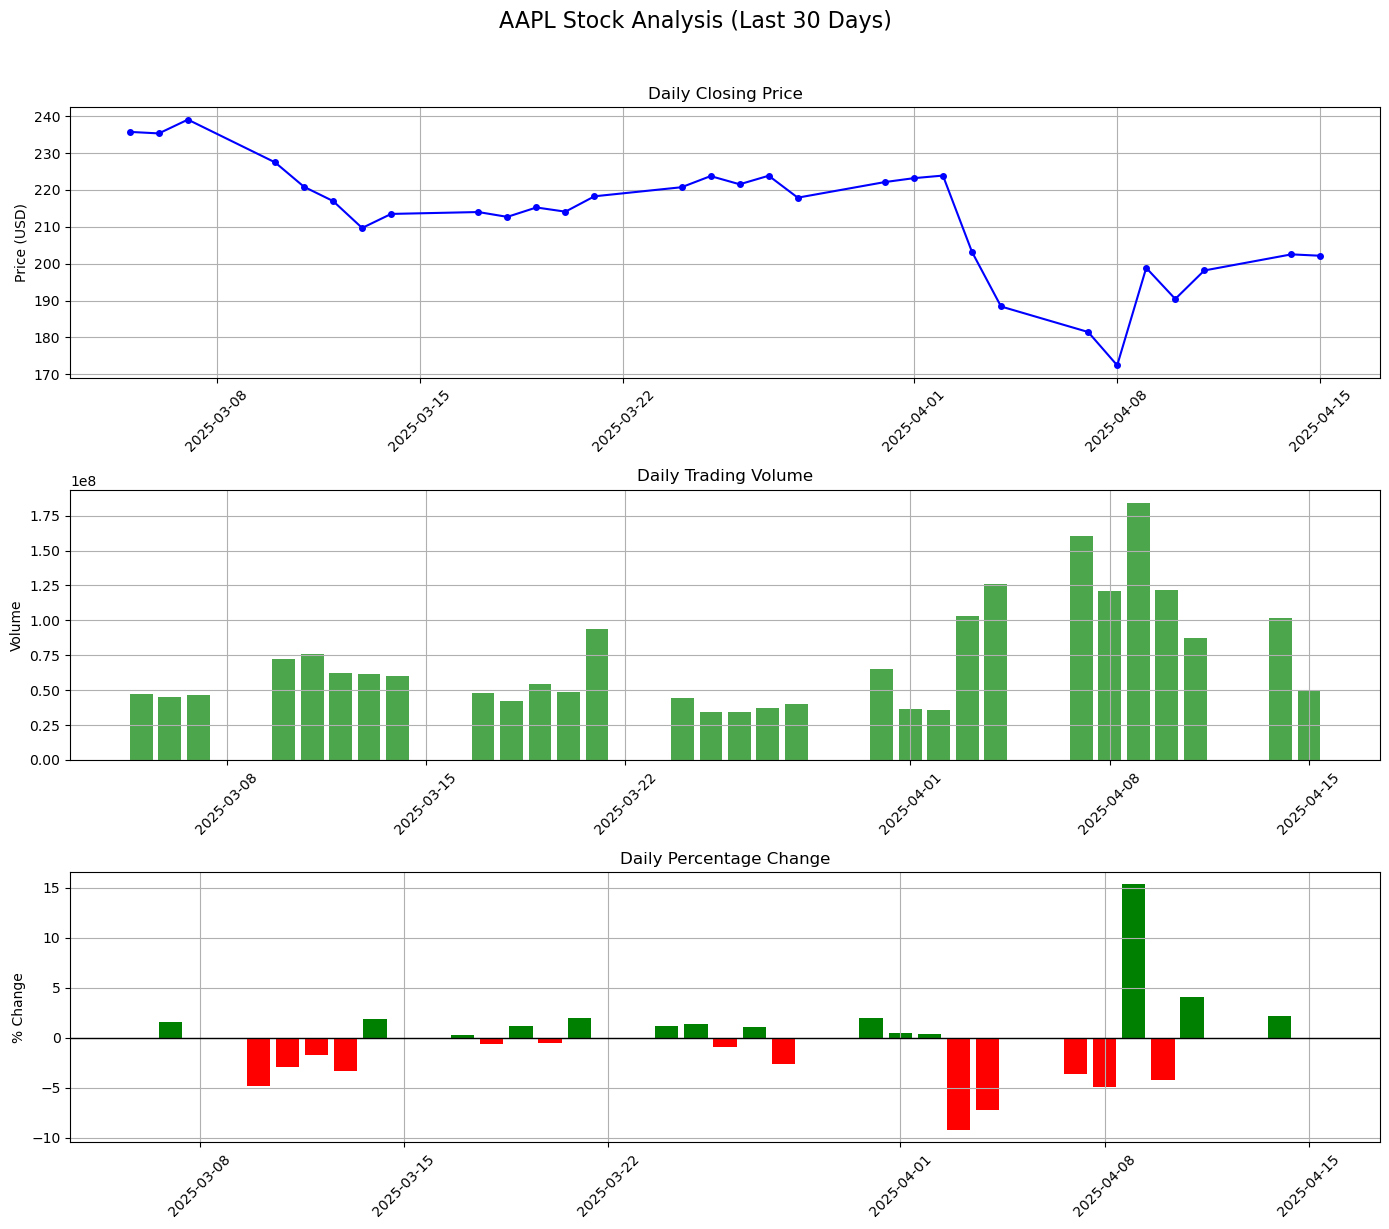


AAPL Summary Statistics (Last 30 Days):
Highest Close: $239.07
Lowest Close: $172.42
Average Volume: 71,420,027
Largest Daily Gain: 15.33%
Largest Daily Drop: -9.25%
--------------------------------------------------


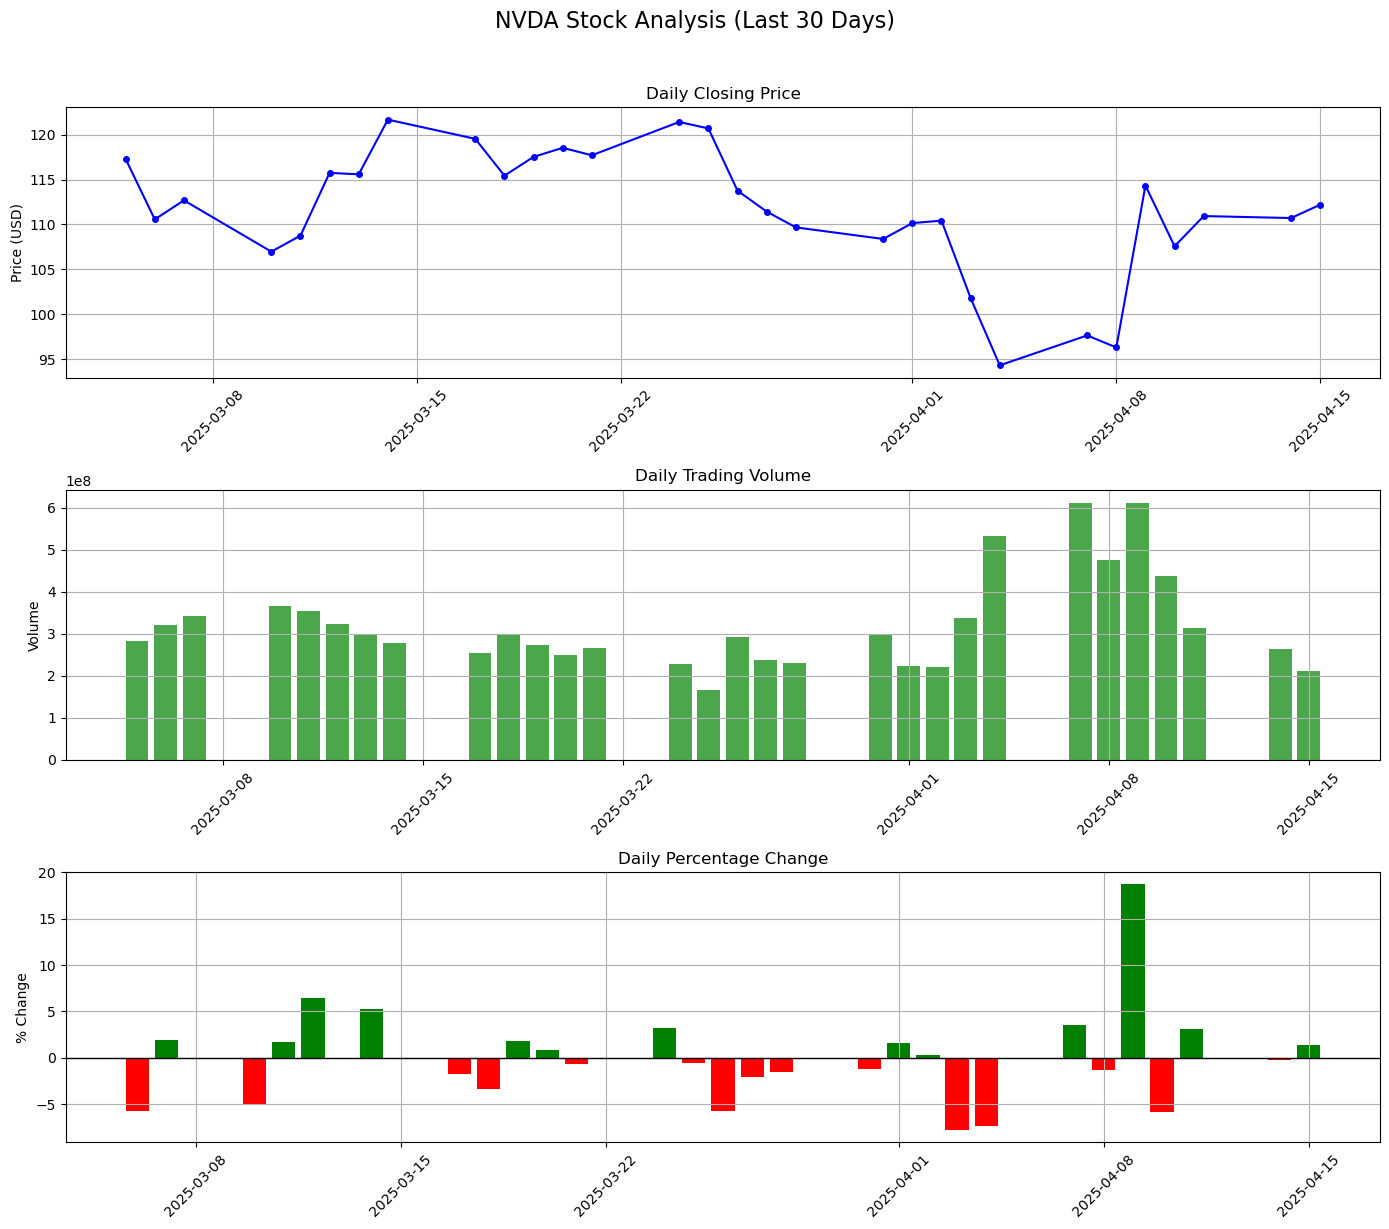


NVDA Summary Statistics (Last 30 Days):
Highest Close: $121.67
Lowest Close: $94.31
Average Volume: 320,328,421
Largest Daily Gain: 18.72%
Largest Daily Drop: -7.81%
--------------------------------------------------


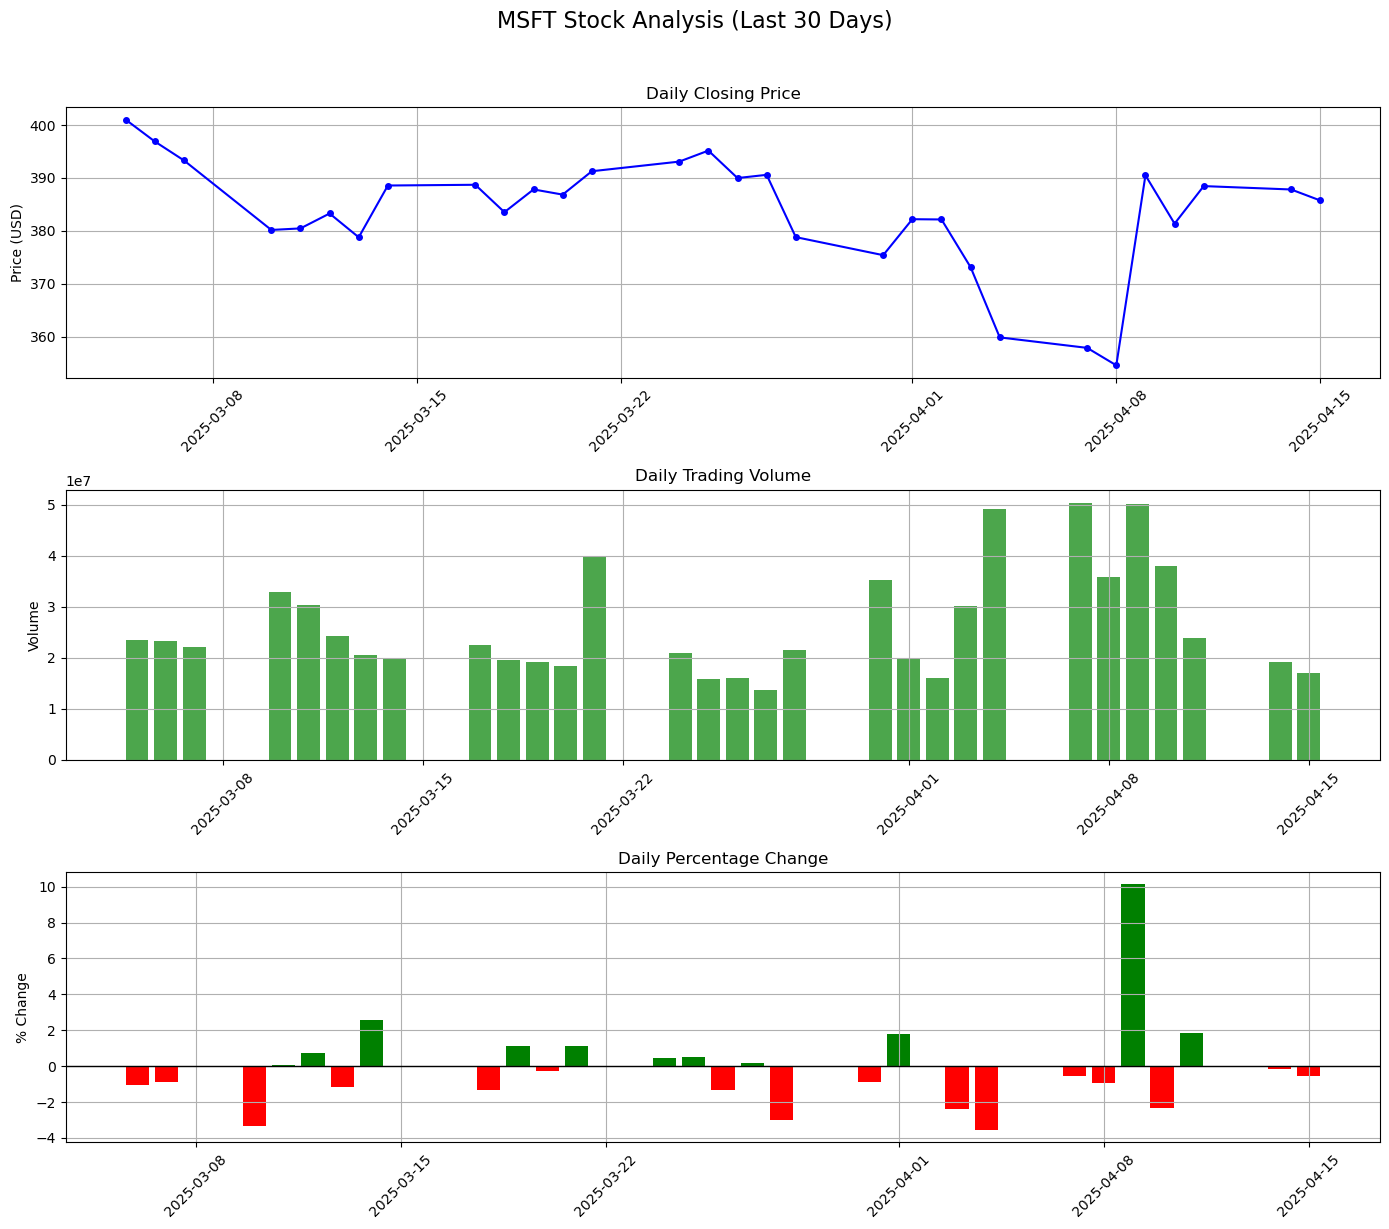


MSFT Summary Statistics (Last 30 Days):
Highest Close: $401.02
Lowest Close: $354.56
Average Volume: 26,310,301
Largest Daily Gain: 10.13%
Largest Daily Drop: -3.56%
--------------------------------------------------


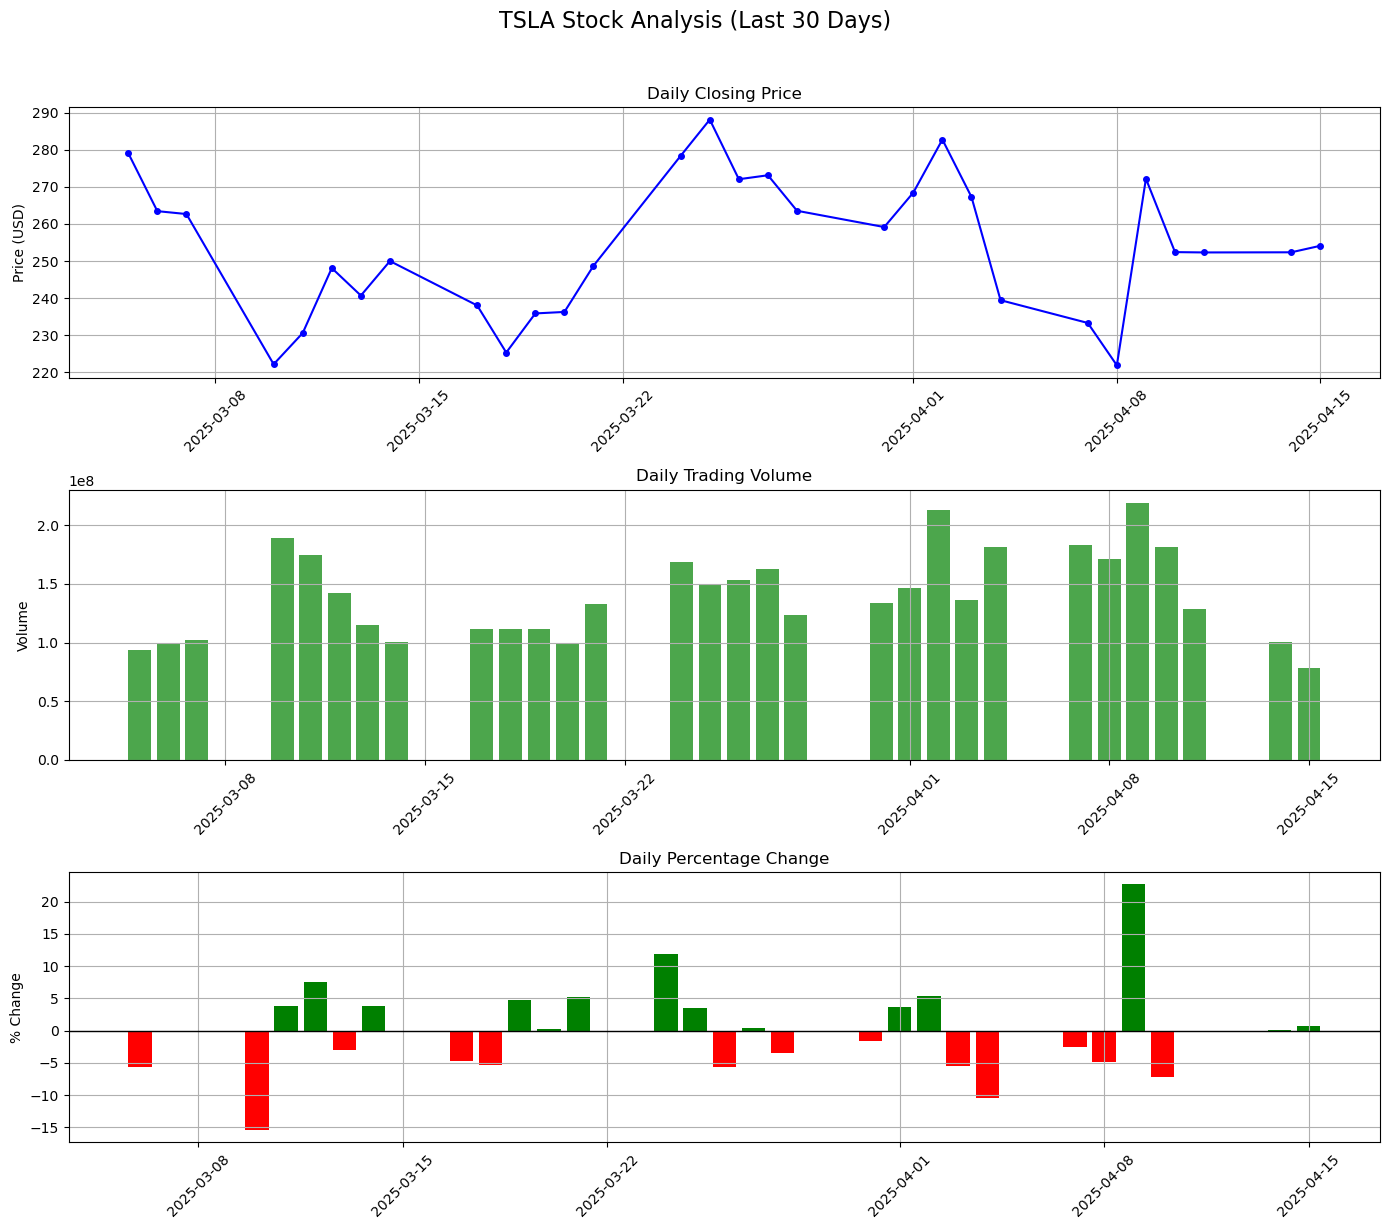


TSLA Summary Statistics (Last 30 Days):
Highest Close: $288.14
Lowest Close: $221.86
Average Volume: 140,562,138
Largest Daily Gain: 22.69%
Largest Daily Drop: -15.43%
--------------------------------------------------


In [10]:
import yfinance as yf
import matplotlib.pyplot as plt

# Define the tickers
tickers = ["AAPL", "NVDA", "MSFT", "TSLA"]

# Get stock data for all tickers
stock_data = yf.download(tickers, period="30d", group_by='ticker')

# Create separate plots for each company
for ticker in tickers:
    # Create figure with 3 subplots (price, volume, % change)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))
    fig.suptitle(f"{ticker} Stock Analysis (Last 30 Days)", fontsize=16, y=1.02)
    
    # Plot closing price
    ax1.plot(stock_data[ticker].index, stock_data[ticker]["Close"], color='blue', marker='o', markersize=4)
    ax1.set_title("Daily Closing Price")
    ax1.set_ylabel("Price (USD)")
    ax1.grid(True)
    
    # Plot trading volume
    ax2.bar(stock_data[ticker].index, stock_data[ticker]["Volume"], color='green', alpha=0.7)
    ax2.set_title("Daily Trading Volume")
    ax2.set_ylabel("Volume")
    ax2.grid(True)
    
    # Plot daily percentage change
    daily_pct_change = stock_data[ticker]["Close"].pct_change() * 100
    ax3.bar(daily_pct_change.index, daily_pct_change, 
            color=['red' if x < 0 else 'green' for x in daily_pct_change])
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax3.set_title("Daily Percentage Change")
    ax3.set_ylabel("% Change")
    ax3.grid(True)
    
    # Format x-axis for all subplots
    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\n{ticker} Summary Statistics (Last 30 Days):")
    print(f"Highest Close: ${stock_data[ticker]['Close'].max():.2f}")
    print(f"Lowest Close: ${stock_data[ticker]['Close'].min():.2f}")
    print(f"Average Volume: {stock_data[ticker]['Volume'].mean():,.0f}")
    print(f"Largest Daily Gain: {daily_pct_change.max():.2f}%")
    print(f"Largest Daily Drop: {daily_pct_change.min():.2f}%")
    print("-" * 50)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


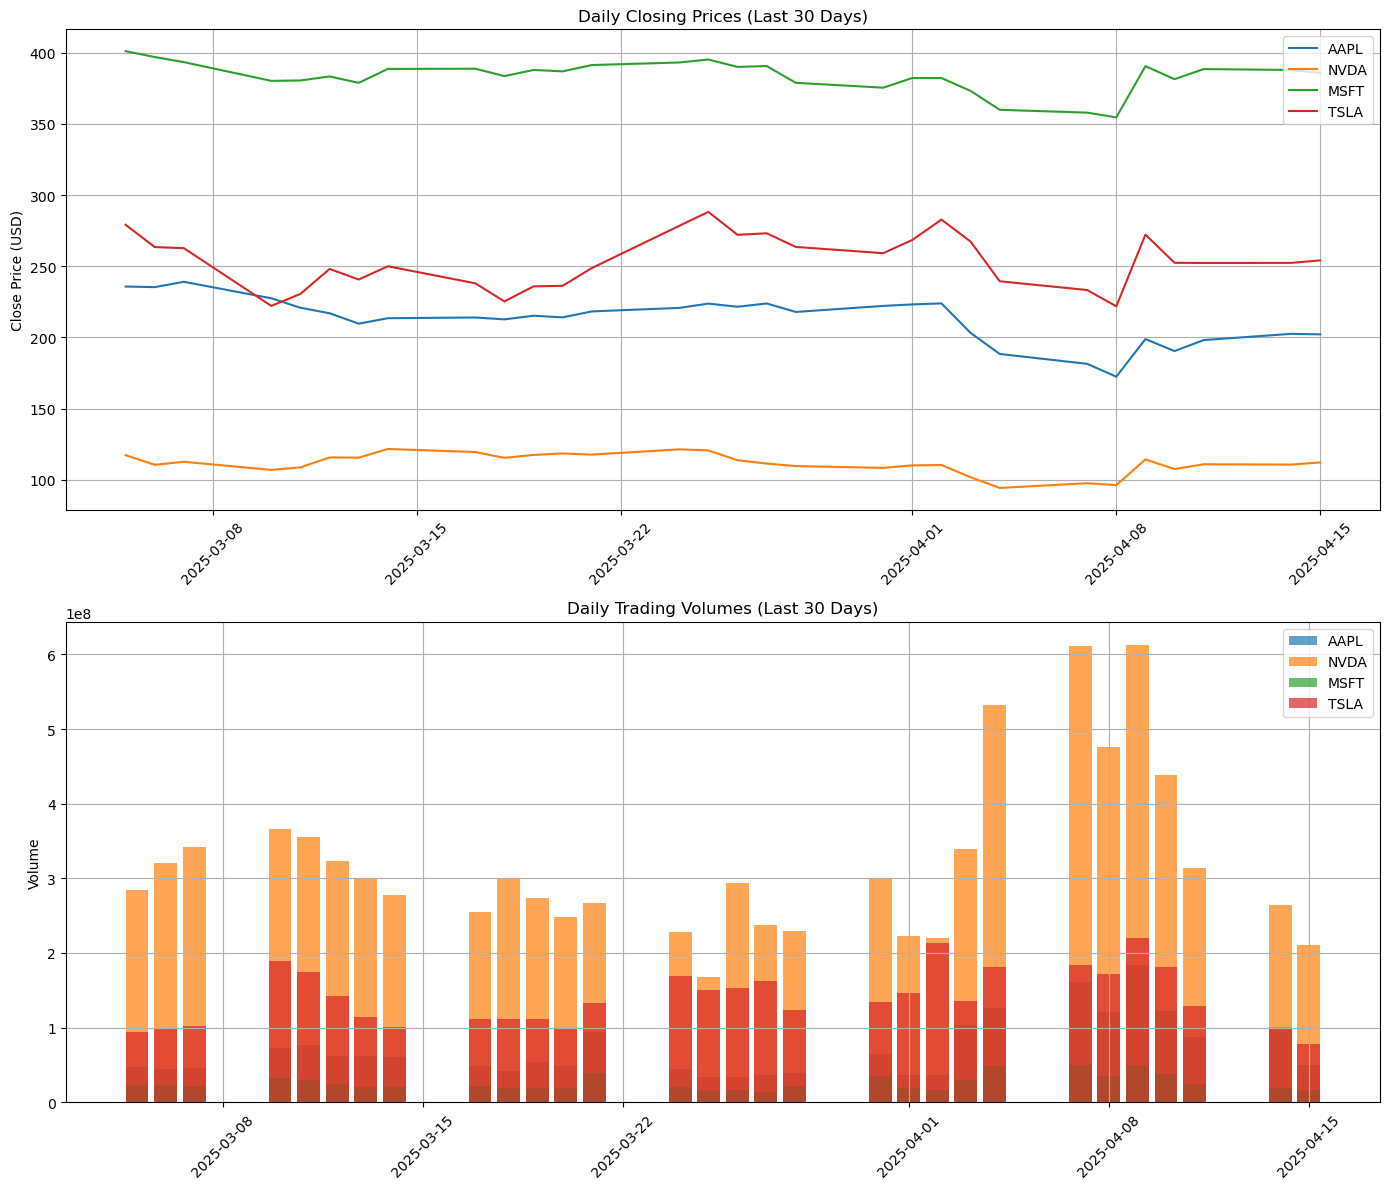

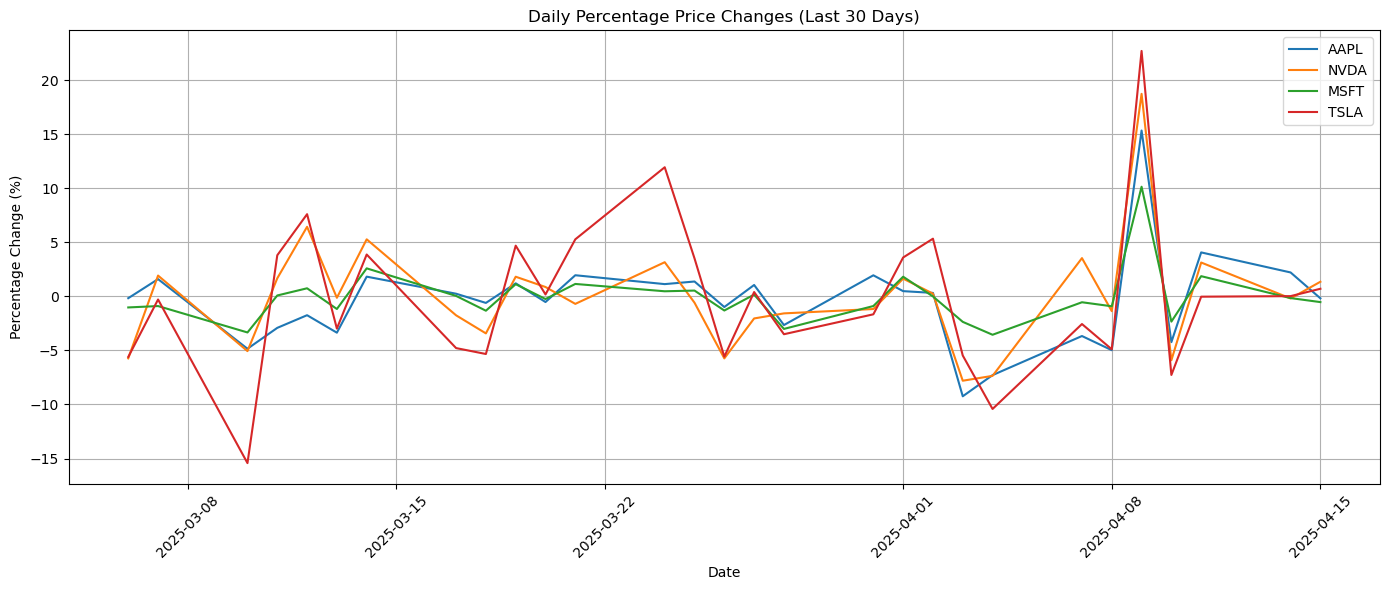

In [8]:
import yfinance as yf
import matplotlib.pyplot as plt

# Define the tickers
tickers = ["AAPL", "NVDA", "MSFT", "TSLA"]

# Get stock data for all tickers
stock_data = yf.download(tickers, period="30d", group_by='ticker')

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plot closing prices
for ticker in tickers:
    ax1.plot(stock_data[ticker].index, stock_data[ticker]["Close"], label=ticker)

ax1.set_title("Daily Closing Prices (Last 30 Days)")
ax1.set_ylabel("Close Price (USD)")
ax1.grid(True)
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Plot trading volumes
for ticker in tickers:
    ax2.bar(stock_data[ticker].index, stock_data[ticker]["Volume"], label=ticker, alpha=0.7)

ax2.set_title("Daily Trading Volumes (Last 30 Days)")
ax2.set_ylabel("Volume")
ax2.grid(True)
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calculate and display daily percentage changes
plt.figure(figsize=(14, 6))
for ticker in tickers:
    daily_pct_change = stock_data[ticker]["Close"].pct_change() * 100
    plt.plot(daily_pct_change.index, daily_pct_change, label=ticker)

plt.title("Daily Percentage Price Changes (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Percentage Change (%)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()